In [76]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    tomato_files = np.array(data['filenames'])
    tomato_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return tomato_files, tomato_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/plantvillage/train/')
valid_files, valid_targets = load_dataset('/content/plantvillage/vaild/')
test_files, test_targets = load_dataset('/content/plantvillage/test/')

# load list of dog names
tomato_names = [item[27:-1] for item in sorted(glob("/content/plantvillage/train/*/"))]

# print statistics about the dataset
print('There are %d total tomato categories.' % len(tomato_names))
print('There are %s total tomato images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training tomato images.' % len(train_files))
print('There are %d validation tomato images.' % len(valid_files))
print('There are %d test tomato images.'% len(test_files))

There are 3 total tomato categories.
There are 1200 total tomato images.

There are 900 training tomato images.
There are 150 validation tomato images.
There are 150 test tomato images.


In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [78]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 150/150 [00:00<00:00, 725.97it/s]


In [79]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 128)      

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs =10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='/content/model.weights.best.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 900 samples, validate on 150 samples
Epoch 1/10
900/900 [==============================] - 2s 3ms/step - loss: 0.6257 - accuracy: 0.7078 - val_loss: 0.2664 - val_accuracy: 0.8667

Epoch 00001: val_loss improved from inf to 0.26639, saving model to /content/model.weights.best.hdf5
Epoch 2/10
900/900 [==============================] - 2s 2ms/step - loss: 0.2907 - accuracy: 0.8822 - val_loss: 0.1827 - val_accuracy: 0.9267

Epoch 00002: val_loss improved from 0.26639 to 0.18272, saving model to /content/model.weights.best.hdf5
Epoch 3/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1480 - accuracy: 0.9478 - val_loss: 0.1770 - val_accuracy: 0.9267

Epoch 00003: val_loss improved from 0.18272 to 0.17696, saving model to /content/model.weights.best.hdf5
Epoch 4/10
900/900 [==============================] - 2s 2ms/step - loss: 0.1246 - accuracy: 0.9556 - val_loss: 0.4754 - val_accuracy: 0.8667

Epoch 00004: val_loss did not improve from 0.17696
Epoch 5/10
900/900 [

In [0]:
model.load_weights('/content/model.weights.best.hdf5')

In [83]:
predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 96.0000%


In [0]:
def predict(img_path):

    predict_vec=model.predict(path_to_tensor(img_path))
    return tomato_names[np.argmax(predict_vec)]
    

In [0]:
def tomato_detect(img_path):
    plt.imshow(plt.imread(img_path))
    plt.show()
    print('that sing mean .....')
    
    print('using CNN .............' ,predict(img_path))
  
    

/content/plantvillage/final/Tomato___Late_blight/3be006f1-7062-47da-a375-8fb7fedb77c0___RS_Late.B 6229.JPG


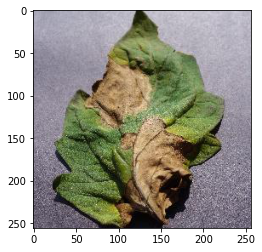

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2e493726-b22f-4e98-a2e2-418a4425cafb___GHLB2 Leaf 8911.JPG


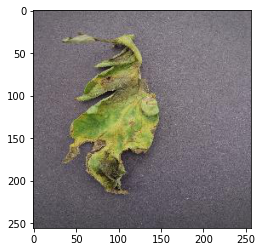

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2e6fd489-d873-4fc6-a908-467765017508___GHLB2 Leaf 151.JPG


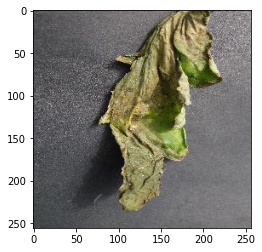

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2f26c159-70bd-4405-b61e-150aaf779c41___RS_Late.B 4919.JPG


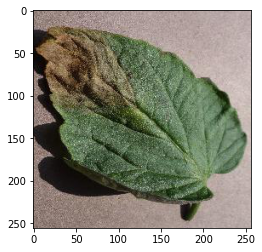

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2e8f61d8-0d5d-46e3-a597-ede96855a4fe___RS_Late.B 5352.JPG


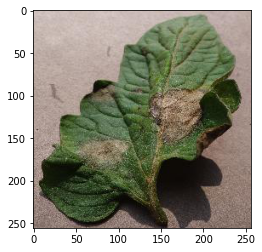

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2e86ab04-c41e-4a4b-a674-552176d72ab1___GHLB2 Leaf 100.JPG


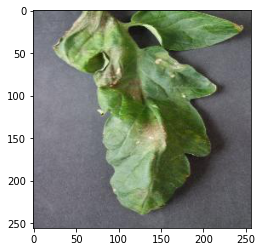

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/03a0f11e-9d47-49c4-ba45-773b8aa9f2e1___GHLB2 Leaf 8767.JPG


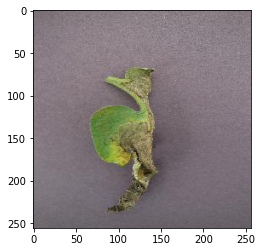

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2f08688f-f6ea-4772-bfa3-5a995e38988c___GHLB2 Leaf 8827.JPG


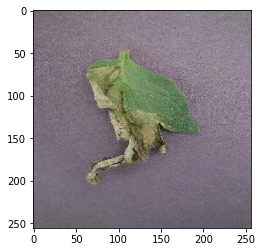

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/3ac52b85-d4a3-4958-9e68-399b919cf7b0___GHLB2 Leaf 8638.JPG


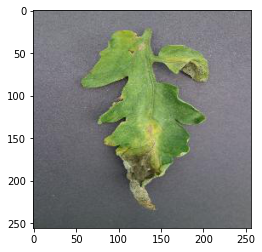

that sing mean .....
using CNN ............. /Tomato___Late_blight
/content/plantvillage/final/Tomato___Late_blight/2ec39ffa-c356-4d31-8153-f2e4bc9a1449___RS_Late.B 5164.JPG


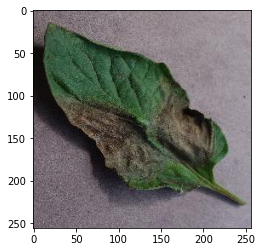

that sing mean .....
using CNN ............. /Tomato___Late_blight


In [86]:
my_file=np.array(glob("/content/plantvillage/final/Tomato___Late_blight/*"))

for i in my_file:
    print(i)
    tomato_detect(i)

/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3e0f8db3-745c-4c20-958f-0f5f51a481de___UF.GRC_YLCV_Lab 02882.JPG


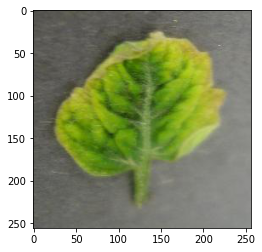

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/04edcd31-202d-43bd-8a61-2985c27e3be3___UF.GRC_YLCV_Lab 01805.JPG


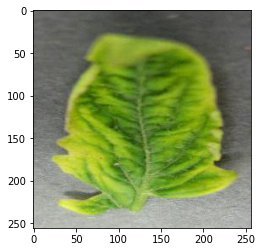

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3df5c84f-cc88-4d4c-af96-ced3261113ab___UF.GRC_YLCV_Lab 01520.JPG


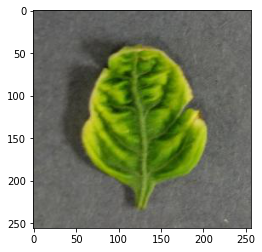

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3f2fd843-100d-4293-b675-cadc7ea8e67a___UF.GRC_YLCV_Lab 08478.JPG


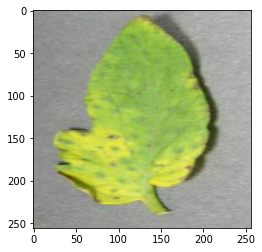

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/4a2e2154-d5cb-4e7f-a616-47cc6185cc94___UF.GRC_YLCV_Lab 01759.JPG


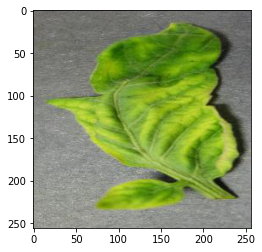

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/04f5d2d8-e08a-4c02-b7fb-89d1edd51110___UF.GRC_YLCV_Lab 09578.JPG


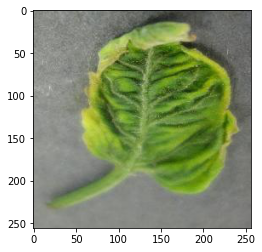

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/4a1c0d21-3ba1-4c62-9e6e-f12b845d54c9___UF.GRC_YLCV_Lab 02699.JPG


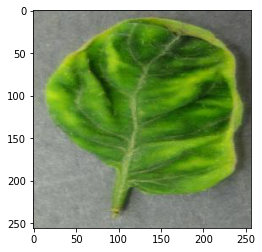

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/3ff06b23-c2c0-4e40-840d-612e53430d08___UF.GRC_YLCV_Lab 02143.JPG


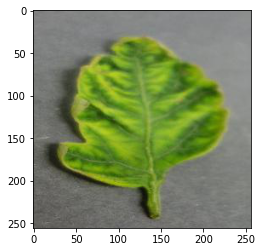

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/04a2f285-b805-4c90-853a-3ee683becb85___UF.GRC_YLCV_Lab 02040.JPG


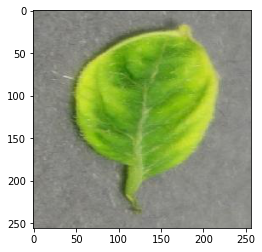

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/04c4e77c-7346-4f27-ac7b-48273cbfb965___UF.GRC_YLCV_Lab 03292.JPG


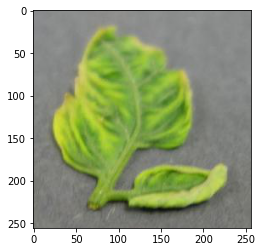

that sing mean .....
using CNN ............. /Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [87]:
my_file=np.array(glob("/content/plantvillage/final/Tomato___Tomato_Yellow_Leaf_Curl_Virus/*"))

for i in my_file:
    print(i)
    tomato_detect(i)

/content/plantvillage/final/Tomato___healthy/2e875abf-377c-4663-a406-e02984215fa6___RS_HL 0499.JPG


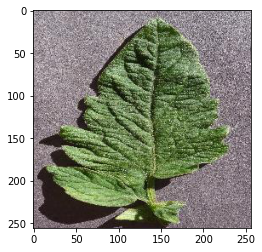

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2e485f1d-5aa5-4d56-8733-9625ed4d000c___GH_HL Leaf 344.JPG


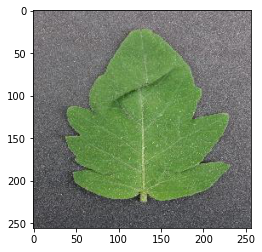

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2ec18b22-c51c-456b-bf94-d5f3d282fb6c___RS_HL 0179.JPG


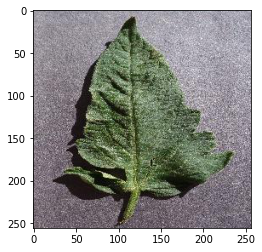

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2fb5c266-b7ec-4b31-91b4-3f2dc9b0cdcb___RS_HL 0147.JPG


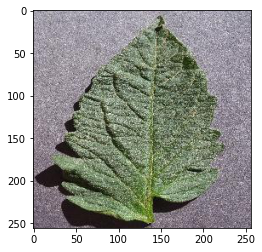

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2f9e1c60-06fc-41e9-af7d-a91c4a5e9f3d___GH_HL Leaf 504.1.JPG


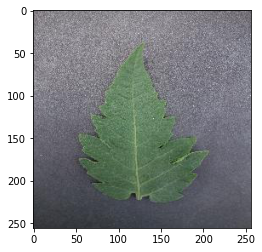

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2ee6d2c6-a766-422c-a710-e89582d8155e___GH_HL Leaf 470.JPG


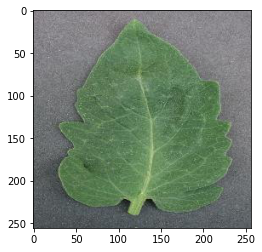

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2eb4a2fa-d41e-47f1-9e3f-e49035c5b24a___RS_HL 9995.JPG


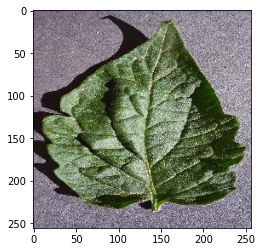

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2ea87b73-a52b-4a4c-938f-4ce06335d171___GH_HL Leaf 177.1.JPG


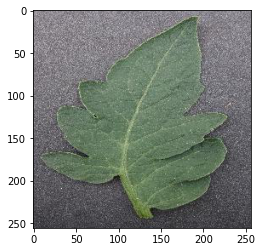

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2e96661f-a313-4deb-bf32-1eacbc10c48d___GH_HL Leaf 424.JPG


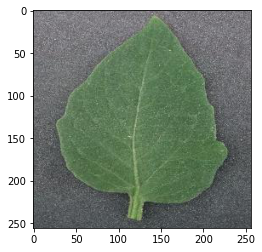

that sing mean .....
using CNN ............. /Tomato___healthy
/content/plantvillage/final/Tomato___healthy/2fd78b0f-a307-4824-9e6c-ff4a3f27e3c8___GH_HL Leaf 403.JPG


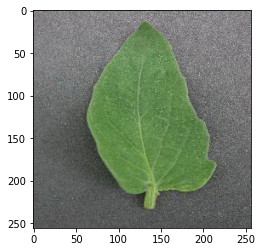

that sing mean .....
using CNN ............. /Tomato___healthy


In [88]:
my_file=np.array(glob("/content/plantvillage/final/Tomato___healthy/*"))

for i in my_file:
    print(i)
    tomato_detect(i)